In [5]:
'''
Author: Sriram Yarlagadda
Date Created: 8/26/2016
Note: Please use Python 2.7
'''
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#os.chdir('C:\Users\syarlag1\Desktop\Loyola-SAH-Analysis') #Set location of home dir here.
os.chdir('/Users/Sriram/Desktop/DePaul/Loyola-SAH-Analysis')#location in Mac

### Reading Data

Only the variables needed are extracted. See the variable "varLst".

In [6]:
os.chdir('./data')
dataFiles = os.listdir('.')
#Names of the variables we need
varLst = ['KEY','LOS','DIED','AGE','SAH','ASA','RACE','PT_INT_SAH','PT_INT_SAH_ASA','SCORE','DISCHARGE_BAD','DISCHARGE_GOOD']
fullDataDict = {}
for fileName in dataFiles:
    dataStr = fileName[:2] + 'Data'; print dataStr #print to confirm that the data is created
    fullDataDict[dataStr] = pd.DataFrame()
    fullDataDict[dataStr] = pd.read_stata(fileName, columns=varLst)
    fullDataDict[dataStr]['KEY'] = fullDataDict[dataStr]['KEY'].astype(str)#Setting the KEY variable as an object   
    #fullDataDict[dataStr].index = fullDataDict[dataStr]['KEY']; del fullDataDict[dataStr]['KEY'] #Setting 'KEY' as index

CAData
FLData
IAData
NYData
WAData


In [7]:
for key in fullDataDict.keys(): #creating a new state identifier column
    fullDataDict[key]['State'] = pd.Series([str(key)[:2]]*fullDataDict[key].shape[0])
allStateData = pd.concat(fullDataDict.values()) #combing into a single dataframe
allStateData.index = range(allStateData.shape[0])

### Data Preprocessing

In [8]:
allStateData.describe()

//anaconda/envs/py2/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,LOS,DIED,AGE,SAH,ASA,RACE,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,DISCHARGE_BAD,DISCHARGE_GOOD
count,38227.000000,38224.000000,38151.000000,38230.0,38230.000000,36868.000000,38230.0,38230.000000,38230.000000,38230.000000,38230.000000
mean,12.151830,0.204871,58.760662,1.0,0.033979,1.838641,1.0,0.033979,5.731389,0.053911,0.300785
std,37.107648,0.406519,16.332432,0.0,0.181145,1.980915,0.0,0.181145,10.280527,0.225886,0.458530
min,-6666.000000,-9.000000,0.000000,1.0,0.000000,-9.000000,1.0,0.000000,0.298197,0.000000,0.000000
25%,NaN,NaN,NaN,1.0,0.000000,NaN,1.0,0.000000,0.932394,0.000000,0.000000
50%,NaN,NaN,NaN,1.0,0.000000,NaN,1.0,0.000000,0.932394,0.000000,0.000000
75%,NaN,NaN,NaN,1.0,0.000000,NaN,1.0,0.000000,6.958751,0.000000,1.000000
max,362.000000,1.000000,111.000000,1.0,1.000000,6.000000,1.0,1.000000,106.059479,1.000000,1.000000


As we can see, there are some abberations. For example, the min of LOS is -6666, which is not possible. Hence we scan for other such outliers and remove the cases that correspond to them.

In [9]:
np.sum(np.array(allStateData < 0),0)

array([  0,   1,   1,   0,   0,   0, 629,   0,   0,   0,   0,   0,   0])

As we can see from the above output, only two features -- LOS and DIED -- have negative values. We look at the cases that correspond to these:

In [10]:
allStateData[allStateData['DIED'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,RACE,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,DISCHARGE_BAD,DISCHARGE_GOOD,State
35104,6.20061320052e+12,1.0,-9.0,46.0,1.0,0.0,1.0,1.0,0.0,6.958751,0.0,0.0,CA


In [11]:
allStateData[allStateData['LOS'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,RACE,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,DISCHARGE_BAD,DISCHARGE_GOOD,State
24518,6.20061082797e+12,-6666.0,0.0,67.0,1.0,0.0,4.0,1.0,0.0,5.473947,0.0,0.0,CA


In [16]:
allStateData[allStateData['RACE'] < 0]; # not showing output (629 cases)

In [17]:
np.sum(np.array(pd.isnull(allStateData)),0)

array([   0,    3,    6,   79,    0,    0, 1362,    0,    0,    0,    0,
          0,    0])

There are **1457** missing values in our data.

We remove all cases which have such outliers:

In [18]:
for feature in allStateData.columns: 
    allStateData = allStateData[allStateData[feature] >= 0] #removing all the cases that are less than 0 (only 2 in our case)

In [19]:
os.chdir('./..') 
allStateData.to_csv('./allStateData.csv') #saving entire file for easy future access

### Data Exploration

In this section we first look at how the cases are distributed by STATE and ASA status and then we visualize the relation between the SCORE, DIED, and LOS variables and the ASA status (0 or 1)

In [20]:
allStateData = pd.read_csv('./allStateData.csv')#ignore this if running script from top

#### First we look at the distribution of the case counts by State and ASA status

**NOTE:** Since we are including the race variable, which has a lot of NaNs, we will have slightly different results from the previous analysis. None of the conclusion have changed. 

Taking a look at the number of cases by state:

In [21]:
allStateData.State.value_counts()

CA    16990
FL     8340
NY     8300
WA     1709
IA      891
Name: State, dtype: int64

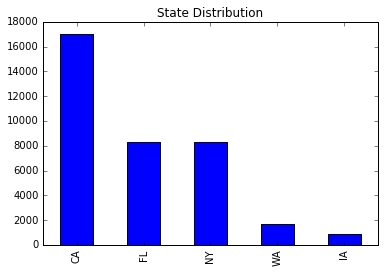

In [22]:
allStateData.State.value_counts().plot('bar')
plt.title('State Distribution')

As seen above, California has the most number of cases, more than the next two (FL and NY) combined.


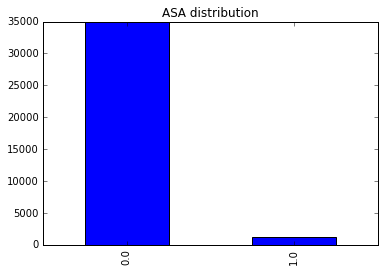

In [23]:
allStateData.ASA.value_counts().plot('bar')
plt.title('ASA distribution')

The above barplot shows us that there are **far fewer** cases of ASA than without ASA

#### We now look at the distribution of the SCORE variable

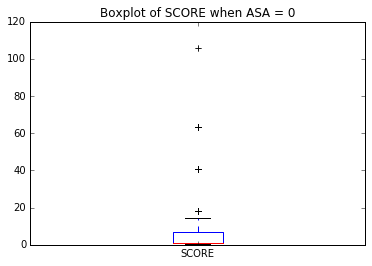

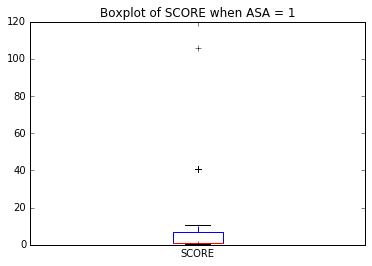

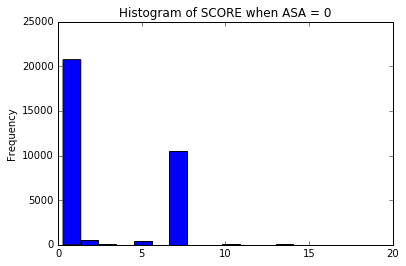

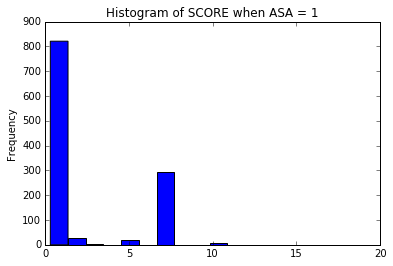

In [24]:
###ASA = 0
allStateData[allStateData.ASA == 0.].SCORE.plot('box')
plt.title('Boxplot of SCORE when ASA = 0'); plt.show()
###ASA == 1
allStateData[allStateData.ASA == 1.].SCORE.plot('box')
plt.title('Boxplot of SCORE when ASA = 1'); plt.show()
###ASA = 0
allStateData[allStateData.ASA == 0.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers
plt.title('Histogram of SCORE when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers
plt.title('Histogram of SCORE when ASA = 1'); plt.show()

From above we can see that both ASA = 1 and ASA = 0 both have a similar distribution for the SCORE variable. However, it is important to notice that these distributions are **NOT** normal. T-tests may **not** be appropriate when the distributions are not normal.

Since there seem to be a lot of discrete values, we also create a cross tabulation (contingency table) of the data with proportions:

In [25]:
pd.crosstab(allStateData.SCORE, allStateData.ASA).apply(lambda x: x/x.sum(), 0).sort_index()

ASA,0.0,1.0
SCORE,,
0.298197,0.015837,0.012019
0.463013,0.000200,0.001603
0.774142,0.000086,0.000000
0.932394,0.576697,0.644231
1.447735,0.008376,0.020833
1.558931,0.000029,0.000000
1.750672,0.000114,0.000000
2.225541,0.006375,0.002404
2.420563,0.001201,0.002404


From the table the main difference between ASA=0 and ASA=1 Scores is at **6.958 and 0.9324**

#### Next we look at the distribution of LOS variable

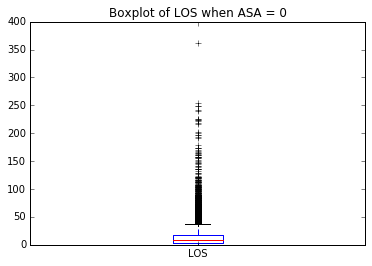

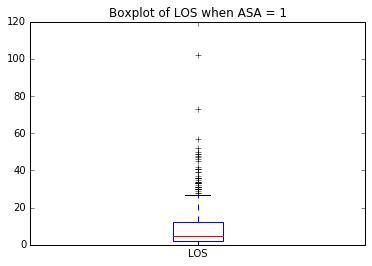

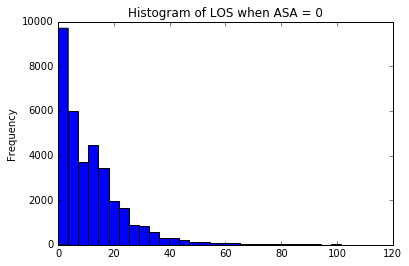

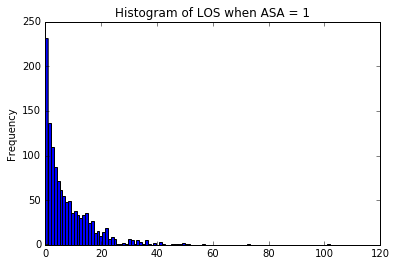

In [26]:
###ASA = 0
allStateData[allStateData.ASA == 0.].LOS.plot('box')
plt.title('Boxplot of LOS when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].LOS.plot('box')
plt.title('Boxplot of LOS when ASA = 1'); plt.show()
###ASA = 0
allStateData[allStateData.ASA == 0.].LOS.plot('hist', xlim=(0,120), bins = 100)
plt.title('Histogram of LOS when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].LOS.plot('hist',  xlim=(0,120), bins = 100)
plt.title('Histogram of LOS when ASA = 1'); plt.show()

Just as before, we can see that the ASA = 1 group and ASA = 0 group both have an approximately similar distribution. And **neither** of these these distributions are normal - seem to have a pareto distribution.

#### Now we look at the distribution of the DIED variable
(Box plots are unnecessary here since the data is boolean (0 or 1))

In [27]:
pd.crosstab(allStateData.DIED, allStateData.ASA).apply(lambda x: x/x.sum(),0)

ASA,0.0,1.0
DIED,,
0.0,0.795095,0.801282
1.0,0.204905,0.198718


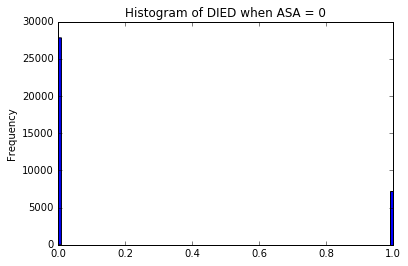

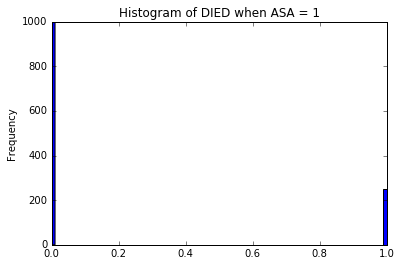

In [28]:
###ASA = 0
allStateData[allStateData.ASA == 0.].DIED.plot('hist', bins = 100)
plt.title('Histogram of DIED when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].DIED.plot('hist', bins = 100)
plt.title('Histogram of DIED when ASA = 1'); plt.show()

The table and plots show us that both the cases almost have the exact same distribution.

### Specific Answers

In [29]:
from scipy import stats  

#### Q1 Is there a relation between Aspirin Usage (ASA) and Hospital Stay (LOS)?

To answer this question, we run a simple Mann-Whitney (Wilcoxon Rank Sum) test on both the groups. Mann-Whitney U tests are preferred over a t-test since the data is very unbalanced and it is not normal. It is essentially a non-parametric alternative to a t-test. Also important to note here, this test is comparing the medians and not the means. Means are really only relevant if the distributions are normal, since CLT doesnt apply otherwise.

Please note here that this variable (LOS) follows a Pareto distribution (see the data exploration part). So it might make sense for us to find a test that is specifically meant for such distributions. I am searching for one and will update this as soon as I find something.

In [30]:
group1_LOS =  allStateData[allStateData.ASA == 0.].LOS
group2_LOS =  allStateData[allStateData.ASA == 1.].LOS

In [31]:
print "The median LOS of ASA = 0 is ", group1_LOS.median()

The median LOS of ASA = 0 is  9.0


In [32]:
print "The median LOS of ASA = 1 is ", group2_LOS.median()

The median LOS of ASA = 1 is  5.0


In [33]:
z_stat, p_val = stats.ranksums(group1_LOS, group2_LOS)
print "p-value: ", p_val  

p-value:  5.25450822196e-31


In [34]:
# Looking at the mean of the LOS variable
print "The mean LOS of ASA = 0 is ", group1_LOS.mean()
print "The mean LOS of ASA = 1 is ", group2_LOS.mean()

The mean LOS of ASA = 0 is  12.55628609
The mean LOS of ASA = 1 is  8.29887820513


Since the p-value is <0.01, there is enough evidence to conclude that the mean Hospital Stay of patients that **do not** use aspirin is **greater** than those that do. However, I am **not** convinced that this is a causal relationship. It could just so happen that patients that are given aspirin are just suffering a less severe SAH and are let out sooner as a result.

#### Q2 Is there a relation between Aspirin Usage (ASA) and Mortality (DIED)?

Since the data here is boolean and independent, I suggest we use a **Chi-Squared test**.

In [35]:
group1_DIED =  allStateData[allStateData.ASA == 0.].DIED
group2_DIED =  allStateData[allStateData.ASA == 1.].DIED

In [36]:
print "The mean SCORE of ASA = 0 is ", group1_DIED.mean()

The mean SCORE of ASA = 0 is  0.20490537991


In [37]:
print "The mean SCORE of ASA = 1 is ", group2_DIED.mean()

The mean SCORE of ASA = 1 is  0.198717948718


In [38]:
ctDIED = pd.crosstab(allStateData.DIED, allStateData.ASA); ctDIED

ASA,0.0,1.0
DIED,,
0.0,27814,1000
1.0,7168,248


In [39]:
p_val = stats.chi2_contingency(ctDIED)[1]
print "p-value: ", p_val  

p-value:  0.619443610554


In [40]:
# even the R implementation of ChiSq test, shows the same result. 
'''
prop.test(c(29341,1037),c(36922,1298),correct=FALSE)

	2-sample test for equality of proportions without
	continuity correction

data:  c(29341, 1037) out of c(36922, 1298)
X-squared = 0.13863, df = 1, p-value = 0.7096
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.02643650  0.01794419
sample estimates:
   prop 1    prop 2 
0.7946753 0.7989214 
'''

'\nprop.test(c(29341,1037),c(36922,1298),correct=FALSE)\n\n\t2-sample test for equality of proportions without\n\tcontinuity correction\n\ndata:  c(29341, 1037) out of c(36922, 1298)\nX-squared = 0.13863, df = 1, p-value = 0.7096\nalternative hypothesis: two.sided\n95 percent confidence interval:\n -0.02643650  0.01794419\nsample estimates:\n   prop 1    prop 2 \n0.7946753 0.7989214 \n'

Since the p-value is >0.05, there is **not** enough evidence to prove that there is a difference in the mortality rate between patients that use aspirin and those that dont.

#### Q3 Is there a relation between Aspirin Usage (ASA) and Severity of SAH (SCORE)?

As seen in the exploration part, this variable is discrete and not really continuous. Mann-Whitney assumes that the distribution is continuous so it might **not** be appropriate here. Hence, we also test using Chi-Sq, which will show if the distributions are similar or not.

In [41]:
group1_SCORE =  allStateData[allStateData.ASA == 0.].SCORE
group2_SCORE =  allStateData[allStateData.ASA == 1.].SCORE

In [42]:
print "The median SCORE of ASA = 0 is ", group1_SCORE.median()

The median SCORE of ASA = 0 is  0.932393848896


In [43]:
print "The median SCORE of ASA = 1 is ", group2_SCORE.median()

The median SCORE of ASA = 1 is  0.932393848896


In [44]:
print "The mean SCORE of ASA = 0 is ", group1_SCORE.mean()

The mean SCORE of ASA = 0 is  5.77974957189


In [45]:
print "The mean SCORE of ASA = 1 is ", group2_SCORE.mean()

The mean SCORE of ASA = 1 is  4.96297010498


In [46]:
z_stat, p_val = stats.ranksums(group1_SCORE, group2_SCORE)#, alternative = 'greater')  
print "p-value: ", p_val  

p-value:  3.84194275899e-05


Since the p-value is <0.01, there is enough evidence to say that the severity of SAH of patients that use aspirin is **lower** than those that don't use aspirin. 

In [47]:
ctSevere = pd.crosstab(allStateData.SCORE, allStateData.ASA); ctSevere

ASA,0.0,1.0
SCORE,,
0.298197,554,15
0.463013,7,2
0.774142,3,0
0.932394,20174,804
1.447735,293,26
1.558931,1,0
1.750672,4,0
2.225541,223,3
2.420563,42,3


In [48]:
p_val = stats.chi2_contingency(ctSevere)[1]
print "p-value: ", p_val

p-value:  1.90580927596e-09


This result shows that the distributions are **NOT** similar. Given that this is the case and the Mann-Whitney test is significant. We can move forward with concluding that Patients on Aspirin and those using it have varying levels of severity of SAH. This does **not** mean that using a higher dose of aspirin results in more severe SAH or vice versa. It just shows that they are related. 

#### Q4 Is there a relation between the discharge status of the patient and ASA?

In [49]:
pd.crosstab([allStateData.DISCHARGE_GOOD,allStateData.DISCHARGE_BAD],allStateData.ASA)

ASA                             0.0  1.0
DISCHARGE_GOOD DISCHARGE_BAD            
0.0            0.0            22332  823
               1.0             1967   41
1.0            0.0            10683  384

Something to note here (see table above) is that of the patients that have **not** been discharged good, only a handful have been discharged bad, a large number of them have are **not** classified as discharged bad. For this analysis, we only use those instances where the patient is either has a discharged_good or discharged_bad of 1. Instances where both these variables are 0 are **not** chosen. 

In [50]:
dataSubset = allStateData[allStateData.DISCHARGE_GOOD+allStateData.DISCHARGE_BAD == 1]; dataSubset.shape # data subset

(13075, 14)

In [51]:
pd.crosstab( [dataSubset.DISCHARGE_GOOD,dataSubset.DISCHARGE_BAD],dataSubset.ASA) # numbers

,ASA,0.0,1.0
DISCHARGE_GOOD,DISCHARGE_BAD,,
0.0,1.0,1967,41
1.0,0.0,10683,384


In [52]:
pd.crosstab(dataSubset.DISCHARGE_GOOD, dataSubset.ASA).apply(lambda x: x/x.sum()) # percentages

ASA,0.0,1.0
DISCHARGE_GOOD,,
0.0,0.155494,0.096471
1.0,0.844506,0.903529


In [53]:
# running a chiSq test in R
'''
prop.test(c(1969,41),c(10731+1969,41+384),correct=FALSE)

	2-sample test for equality of proportions without continuity
	correction

data:  c(1969, 41) out of c(10731 + 1969, 41 + 384)
X-squared = 10.877, df = 1, p-value = 0.0009735
alternative hypothesis: two.sided
95 percent confidence interval:
 0.02980288 0.08733468
sample estimates:
    prop 1     prop 2 
0.15503937 0.09647059 
'''

'\nprop.test(c(1969,41),c(10731+1969,41+384),correct=FALSE)\n\n\t2-sample test for equality of proportions without continuity\n\tcorrection\n\ndata:  c(1969, 41) out of c(10731 + 1969, 41 + 384)\nX-squared = 10.877, df = 1, p-value = 0.0009735\nalternative hypothesis: two.sided\n95 percent confidence interval:\n 0.02980288 0.08733468\nsample estimates:\n    prop 1     prop 2 \n0.15503937 0.09647059 \n'

Although the test is significant and the confidence interval tells us that patients on Aspirin have a higher proportion of better discharge than those who are not on aspirin. The sample size for the patients not using Aspirin is so small, that I would **not** draw any conclusions from this. 

### Q5 Is there a relation between the race of the patient and SAH score ?
#### KEY:
1-White;
2-Black;
3-Hispanic;
4-Asian;
0-Other

The there are 6 race values in the data (there are only 5 listed above). Also the race IDs start at 1 in the data.

In [54]:
ctRACE = pd.crosstab(allStateData.SCORE,allStateData.RACE); ctRACE

RACE,1.0,2.0,3.0,4.0,5.0,6.0
SCORE,,,,,,
0.298197,280,82,115,52,2,38
0.463013,2,1,3,1,0,2
0.774142,0,0,0,3,0,0
0.932394,11747,2277,4400,1438,41,1075
1.447735,177,37,59,28,2,16
1.558931,0,1,0,0,0,0
1.750672,2,0,0,0,0,2
2.225541,122,35,37,15,1,16
2.420563,20,6,13,4,0,2


In [55]:
pd.crosstab(allStateData.SCORE,allStateData.RACE).apply(lambda x: x/x.sum()) # percentages

RACE,1.0,2.0,3.0,4.0,5.0,6.0
SCORE,,,,,,
0.298197,0.014088,0.019773,0.015438,0.018719,0.021739,0.020116
0.463013,0.000101,0.000241,0.000403,0.000360,0.000000,0.001059
0.774142,0.000000,0.000000,0.000000,0.001080,0.000000,0.000000
0.932394,0.591044,0.549072,0.590683,0.517639,0.445652,0.569084
1.447735,0.008906,0.008922,0.007921,0.010079,0.021739,0.008470
1.558931,0.000000,0.000241,0.000000,0.000000,0.000000,0.000000
1.750672,0.000101,0.000000,0.000000,0.000000,0.000000,0.001059
2.225541,0.006138,0.008440,0.004967,0.005400,0.010870,0.008470
2.420563,0.001006,0.001447,0.001745,0.001440,0.000000,0.001059


In [56]:
p_val = stats.chi2_contingency(ctRACE)[1]
print "p-value: ", p_val  

p-value:  3.69055252772e-17


P-value < 0.01 so there are difference in the scores between the various races. 

In [57]:
# These are the mean scores for each race
allStateData.groupby('RACE')['SCORE'].mean()

RACE
1.0    5.545185
2.0    6.028415
3.0    5.666142
4.0    7.036609
5.0    7.724902
6.0    5.667084
Name: SCORE, dtype: float64

As we can see there is a clear difference in the means. We perform a ANOVA to test the statistical significance of this difference. 

In [58]:
race_1 = allStateData[allStateData.RACE == 1].SCORE;  race_2 = allStateData[allStateData.RACE == 2].SCORE;
race_3 = allStateData[allStateData.RACE == 3].SCORE;  race_4 = allStateData[allStateData.RACE == 4].SCORE;
race_5 = allStateData[allStateData.RACE == 5].SCORE;  race_6 = allStateData[allStateData.RACE == 6].SCORE; 
racesLst = [allStateData[allStateData.RACE == x].SCORE for x in range(1,7)]

In [59]:
stats.f_oneway(race_1, race_2, race_3, race_4, race_5, race_6)

F_onewayResult(statistic=11.666526608046929, pvalue=2.7430732442263212e-11)

The p-value < 0.01 indicates a significant ANOVA, i.e., the means are different.
Let us now compare each race with the other to see the results.

In [60]:
from statsmodels.stats.weightstats import ttest_ind
pVals = {}
for race_i in range(len(racesLst)):
    for race_j in range(len(racesLst)):
        if race_i == race_j: continue
        else:
            pVals[(race_i+1,race_j+1)] = ttest_ind(racesLst[race_i],racesLst[race_j], 'larger')[1]

In [61]:
pVals

{(1, 2): 0.99740379078161834,
 (1, 3): 0.81071709311802609,
 (1, 4): 0.99999999999963596,
 (1, 5): 0.98103037236755886,
 (1, 6): 0.69299736631358111,
 (2, 1): 0.0025962092183816361,
 (2, 3): 0.03590336251107714,
 (2, 4): 0.99990443805822371,
 (2, 5): 0.93605647036930439,
 (2, 6): 0.10488508807033055,
 (3, 1): 0.18928290688197391,
 (3, 2): 0.96409663748892283,
 (3, 4): 0.99999999572908282,
 (3, 5): 0.97134820501396901,
 (3, 6): 0.50142372867481899,
 (4, 1): 3.6398618969155618e-13,
 (4, 2): 9.5561941776298889e-05,
 (4, 3): 4.27091718648795e-09,
 (4, 5): 0.71042461789641864,
 (4, 6): 1.6533399704889659e-05,
 (5, 1): 0.01896962763244112,
 (5, 2): 0.063943529630695578,
 (5, 3): 0.028651794986030991,
 (5, 4): 0.28957538210358141,
 (5, 6): 0.028525690626844659,
 (6, 1): 0.30700263368641889,
 (6, 2): 0.89511491192966952,
 (6, 3): 0.49857627132518095,
 (6, 4): 0.99998346660029513,
 (6, 5): 0.97147430937315538}

**Conclusions**

As seen from the p-values: The following conclusions can be drawn: (using alpha of 0.01)
- race2 has higher mean than race1
- race4 has higher mean than race1
- race4 has higher mean than race2
- race4 has higher mean than race3
- race4 has higher mean than race6
- race5 has higher mean than race1

### Q6 Is there a relation between the age of the patient and SAH score ?

(array([   65.,   539.,  1615.,  4169.,  9376.,  8668.,  6186.,  4747.,
          849.,    16.]),
 array([   0. ,   11.1,   22.2,   33.3,   44.4,   55.5,   66.6,   77.7,
          88.8,   99.9,  111. ]),
 <a list of 10 Patch objects>)

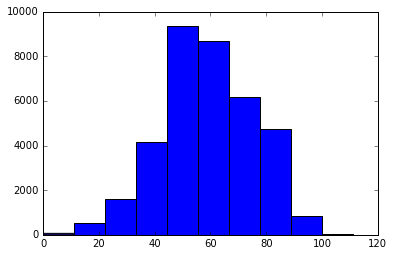

In [62]:
# distribution of age values in the data
plt.hist(allStateData.AGE)

let us take a look at the correlation between the AGE of the patient and his/her score

In [63]:
stats.pearsonr(allStateData.AGE, allStateData.SCORE)[0]

0.037332795129763889

This indicates that there is really no correlation. But let us take a look at the means.

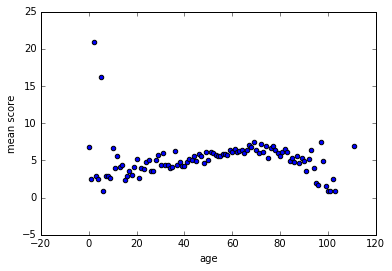

In [64]:
# let us also look at how the (mean) score varies with age
meanScoreByAge = allStateData.groupby('AGE')['SCORE'].mean()
plt.scatter(meanScoreByAge.index, meanScoreByAge)
plt.xlabel('age'); plt.ylabel('mean score')
df_AgeScore = pd.DataFrame({'AGE':meanScoreByAge.index, 'SCORE':meanScoreByAge})

Looking at this plot there seems to be a linear increase in the score going from 20 to 70 years and then a drop from 70 to 100 years. Let us take a look at the correlations for these ranges.

In [65]:
# 20years to 70years
age20_70 =df_AgeScore[(df_AgeScore.AGE>20) & (df_AgeScore.AGE<70)].AGE 
score20_70 = df_AgeScore[(df_AgeScore.AGE>20) & (df_AgeScore.AGE<70)].SCORE
stats.pearsonr(age20_70, score20_70)[0]

0.81234396723046531

In [66]:
# 70years to 100years
age70_100 =df_AgeScore[(df_AgeScore.AGE>70) & (df_AgeScore.AGE<100)].AGE
score70_100 = df_AgeScore[(df_AgeScore.AGE>70) & (df_AgeScore.AGE<100)].SCORE
stats.pearsonr(age70_100, score70_100)[0]

-0.62974811515403373

Based on these values, we can conclude that there is some correaltion between age and score. In the 20 to 70 year group, there is a 81% correlation. And in the 70 to 100 year group there is a -63% correlation (decreasing).

Let us now conduct some hypothesis test on these values to check if they are statistically significant:

In [67]:
# 20years to 70years
stats.pearsonr(age20_70, score20_70)[1]

1.3869377395118408e-12

In [68]:
# 70years to 100years
stats.pearsonr(age70_100, score70_100)[1]

0.00025171174106927653

From the above results we can see that both tests are significant using at $\alpha$ of 0.05.